## Imports

## Initializing params

In [26]:
import numba

In [27]:
numba.__version__

'0.48.0'

In [ ]:
python --version

In [18]:
from numba import jit
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f as ft
from scipy.stats import t
from time import time
import warnings
from decimal import *
getcontext().prec = 6
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
#Pradhyumn
df = pd.read_excel(r'C:\Users\91836\Desktop\books\sem 4\BT2022 Biostats\data4.xlsx')
# Sahana
# df = pd.read_excel('/Users/Pradhyumn/Downloads/dataset_all.xlsx') 
# Ishaan
#df = pd.read_excel('/Users/Pradhyumn/Downloads/data4.xlsx') 


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

start = time()

In [19]:
y_actual = list(df.Y)

a = 1.0
b = -1.7
c = 0.5
d = 1.0
h = 0.2

params = [a,b,c,d,h]
E = 2
lamd = 50
step = 1e-6

## Differential Equation

$ \frac{df(x)}{d(x)} = dsin(x^2) - a\sin(hxf(x)) - bcos(x{f(x)}^2) - csin(x{f(x)}^3) $

## $\chi^2$

In [20]:
@jit(nopython = True)
def f(params,y_actual):
    a = params[0] 
    b = params[1] 
    c = params[2] 
    d =  params[3] 
    h = params[4] 
    dx = 0.1
    X = np.arange(0,10,dx)
    y_pred = [0.0]    
    for i in range(len(X)):
        x = X[i]
        y = y_pred[i]
        estimate = y + (((d*(np.sin(x**2))) - a*np.sin(h*x*y) - b*np.cos(x*y**2) - c*np.sin(x*y**3))*dx)
        y_pred.append(estimate)

    y_pred = y_pred[:]
    y_actual = y_actual[:]
    chi2 = list(map(lambda x,y : (x - y)**2, y_actual, y_pred))
    del_y = list(map(lambda x,y : (x - y), y_actual, y_pred))
    sum = 0
    for i in chi2:
        sum = sum + i

    return sum, np.array(y_pred), np.array(del_y)

## Jacobian

In [21]:
@jit(nopython = True)
def temp(params, y_actual):

    dp = step
    jmat = []
    for i in range(5):
        new_params = [i for i in params]
        new_params[i] = params[i] + dp
        # Derivative 
        jmat.append((f(new_params,y_actual)[1] - f(params,y_actual)[1])/dp)
        
        
    return jmat

def J(params):
    return np.matrix(temp(params, y_actual)).T


##  Marquart-Levenberg Algorithm

In [22]:
_, y_pred, del_y = f(params,y_actual)
jmat = J(params)
i = 0
s = 1
while (s > 1e-12):
    
    chi2_old = f(params,y_actual)[0]
    del_y = del_y.reshape(-1,1)
    params = np.array(params).reshape(-1,1)
    new_params = params + ((jmat.T*jmat) + lamd * np.diag(np.diag(jmat.T * jmat)))**-1 * jmat.T * del_y
    new_params = list(np.array(new_params).flatten())
    params = list(params.flatten())
    chi2_new = f(new_params, y_actual)[0]
    
    if chi2_new > chi2_old:
        if lamd*E < 10**8:
            lamd = lamd * E
            s = abs(chi2_new - chi2_old)
            
    else:
        if lamd / E > 10**-3:
            lamd = lamd / E
        params = new_params
        jmat = J(params)
        chi2_new, _, del_y = f(params,y_actual)
        s = abs(chi2_new - chi2_old)
        chi2_old = chi2_new
        i = i+1
    

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mInvalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float64, 1d, C), float64)
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 2:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 3:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 4:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 5:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 6:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 7:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 8:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 9:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 10:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 11:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 12:[0m
[1m    TypeError: unsupported array index type float64 in [float64][0m
    raised from C:\Users\91836\anaconda3\lib\site-packages\numba\typing\arraydecl.py:71
[1mIn definition 13:[0m
[1m    TypeError: unsupported array index type float64 in [float64][0m
    raised from C:\Users\91836\anaconda3\lib\site-packages\numba\typing\arraydecl.py:71
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: typing of intrinsic-call at <ipython-input-20-ae95de9dc2f6> (12)[0m
[1m
File "<ipython-input-20-ae95de9dc2f6>", line 12:[0m
[1mdef f(params,y_actual):
    <source elided>
    for i in range(len(X)):
[1m        x = X[i]
[0m        [1m^[0m[0m


## Anova

In [6]:
y_pred = f(params,y_actual)[1]

# Sum of Squared errors between mean Y and regression predictions
SSR = np.sum((y_pred - np.mean(y_actual))**2)
SSR_df = 1
MSR = SSR/SSR_df

# Sum of Squared errors between actual values and regression predictions
SSE = np.sum((y_pred - y_actual)**2)
SSE_df = 101 - 1 - 1
MSE = SSE/SSE_df

# Total sum of squared errors
SST = SSE + SSR
SST_df = SSE_df + SSR_df
MST = MSE + MSR

# R^2
R_2 = SSR/SSR

# Adjusted R^2
adjR_2 = 1 - (1-R_2) * (101-1) / (101-1-1)

# Root Mean Squared Error
RMSE = (SSE / (101-1-1))**0.5

#Performing F test for checking if difference in variance is significant
F = MSR/MSE
pvalue_F = (1 - ft.cdf(F,SSR_df,SSE_df))*2

index = ['SSR', 'SSE', 'Total']
Anova = pd.DataFrame([SSR,SSE,SST], index = index, columns = ['Sum of Squares'])
Anova['df'] = [SSR_df,SSE_df,SST_df]
Anova['Mean Error'] = [MSR,MSE,MST]
Anova
print(f'\nF Score : {F}\np value : {pvalue_F}\nR_2 : {R_2}\nAdjusted R_2 : {adjR_2}\nRMSE : {RMSE}')

,Sum of Squares,df,Mean Error
SSR,10.173371,1,10.173371
SSE,0.011221,99,0.000113
Total,10.184592,100,10.173484



F Score : 89759.21764809637
p value : 2.220446049250313e-16
R_2 : 1.0
Adjusted R_2 : 1.0
RMSE : 0.010646158163816491


## Error Analysis

In [7]:
cov_mat = (jmat.T*jmat)**-1 * SSE / (101-1-1)
cov_diag = np.diag(cov_mat)
std_err = cov_diag**0.5
t_vals = np.array(params) / std_err

p_vals1 = ((1- t.cdf(t_vals, 101-1-1))*2)
p_vals2 = (t.cdf(t_vals, 101-1-1))*2
p_vals = [min(a,b) for a,b in zip(p_vals1, p_vals2)]

alpha = 0.02563
std_alpha = abs(t.ppf(alpha/2,101-1-1))*std_err

index = ['a','b','c','d','h']
err = pd.DataFrame(params, index = index, columns = ['Value'])
err['Std Error'] = std_err
err['t value'] = t_vals
err['p value'] = p_vals
err['Error at 2.563%'] = std_alpha
err

print(f'Covarinace [4,4] = {cov_mat[4,4]}')
print(f'Lambda = {lamd}')
print(f'Iterations = {i}')


,Value,Std Error,t value,p value,Error at 2.563%
a,1.147038,0.238384,4.811716,5.365953e-06,0.540173
b,-1.876034,0.009530,-196.852286,3.256518e-130,0.021595
c,0.572188,0.025649,22.308507,0.000000e+00,0.058120
d,1.412780,0.010943,129.101399,0.000000e+00,0.024797
h,0.210587,0.047014,4.479282,2.010897e-05,0.106531


Covarinace [4,4] = 0.0022102696208893564
Lambda = 0.00152587890625
Iterations = 22


## Visualize!

<Figure size 2160x720 with 0 Axes>

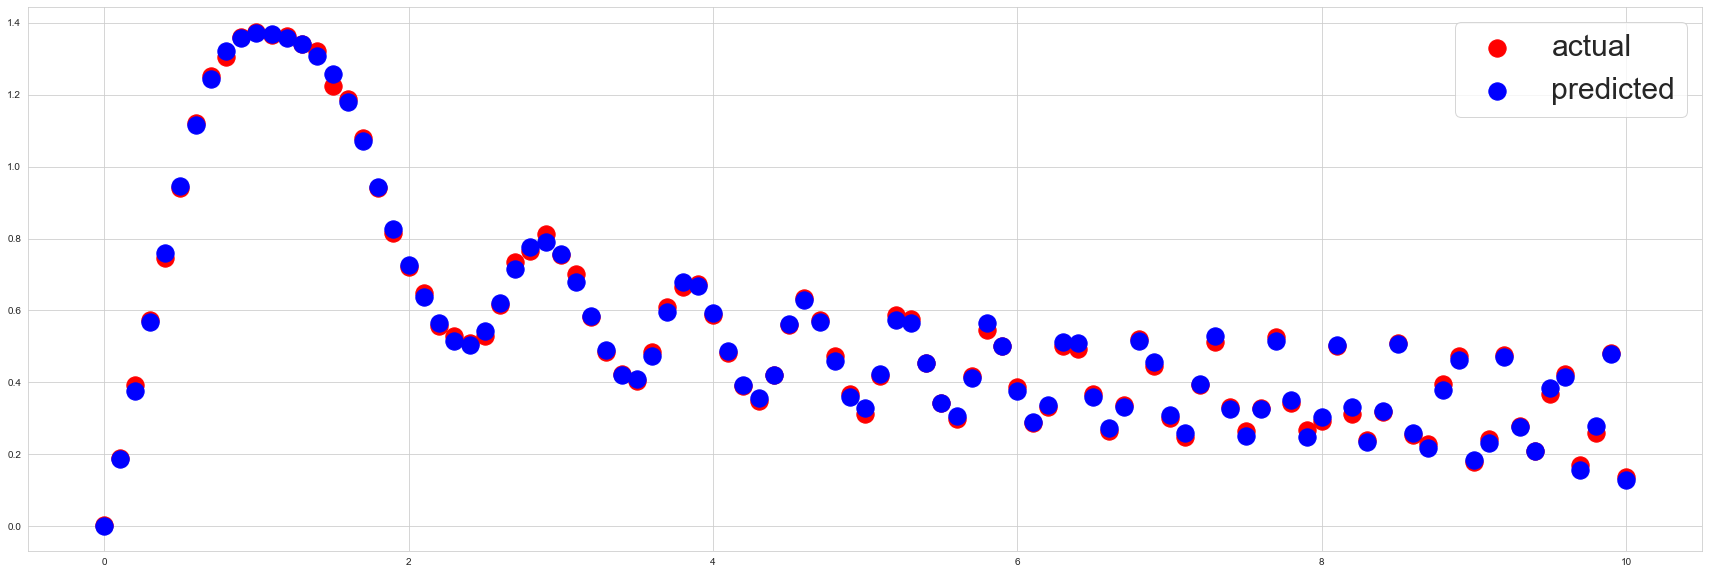

Time to run : 38.346197843551636


In [8]:
pred = f(params,y_actual)[1]
plt.figure(figsize = (30,10));
plt.scatter(x = df.X, y = df.Y, facecolor = 'red', edgecolor = 'red', s = 300, label = 'actual');
plt.scatter(x = df.X, y = pred, facecolor = 'blue', edgecolor = 'blue', s = 300, label = 'predicted');
plt.legend(prop = {"size" : 30})
plt.show()
end = time()
print(f'Time to run : {end - start}')